In [1]:
%load_ext autoreload
%autoreload 2

# Time Series Classification (and More) Without Labels: A Primer on Human Activity Detection Data

In [ ]:
import os
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import umap.plot
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
from umap import UMAP

In [3]:
sys.path.append(
    os.path.join(
        Path(os.getcwd()).parents[0].as_posix(),
        "src"
    )
)

sys.path.append(
    os.path.join(
        Path(os.getcwd()).parents[0].as_posix(),
        "src",
        "ca_tcc"
    )
)

In [4]:
from ca_tcc.config_files.HAR_Configs import Config
from ca_tcc.models.model import BaseModel
from ca_tcc.models.TC import TC
from ca_tcc.trainer.trainer import run_model_training
from ca_tcc.utils import _logger
from data import HARDataController

In [5]:
idx = pd.IndexSlice

## Intro

When training a model to classify time series data (i.e. figuring out what different continuous chunks of measurements might represent), there are benefits to introducing a self-supervised task aimed at learning the data before doing any training on labelled data.

## Loading HAR Data

We'll be working with Human Activity Detection dataset - it consists of inertial sensor data that was collected using a smartphone carried by 30 subjects:

In [6]:
%%HTML
<div align="center">
    <iframe 
        width="560" 
        height="315"
        src="https://www.youtube.com/embed/XOEN9W05_4A?si=msCoG9kEvLrxkKVi" 
        title="HAR Demo Video" 
        frameborder="0" 
        allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" 
        referrerpolicy="strict-origin-when-cross-origin" 
        allowfullscreen
    ></iframe>
</div>

Activities which were performed: 
- Walking
- Walking Upstairs
- Walking Downstairs
- Sitting
- Standing
- Laying

From https://paperswithcode.com/dataset/har

In [7]:
dc = HARDataController()

In [8]:
dc.load()

In [9]:
label_to_name_map = dc.df_test_y.groupby(
    ['label', 'name'], as_index=False
).size().drop(columns=['size']).set_index('label').to_dict()['name']

### Data Summaries

Raw data comprises 128 readings of 9 channels: x-y-z of body acceleration, body gyroscope and total acceleration:

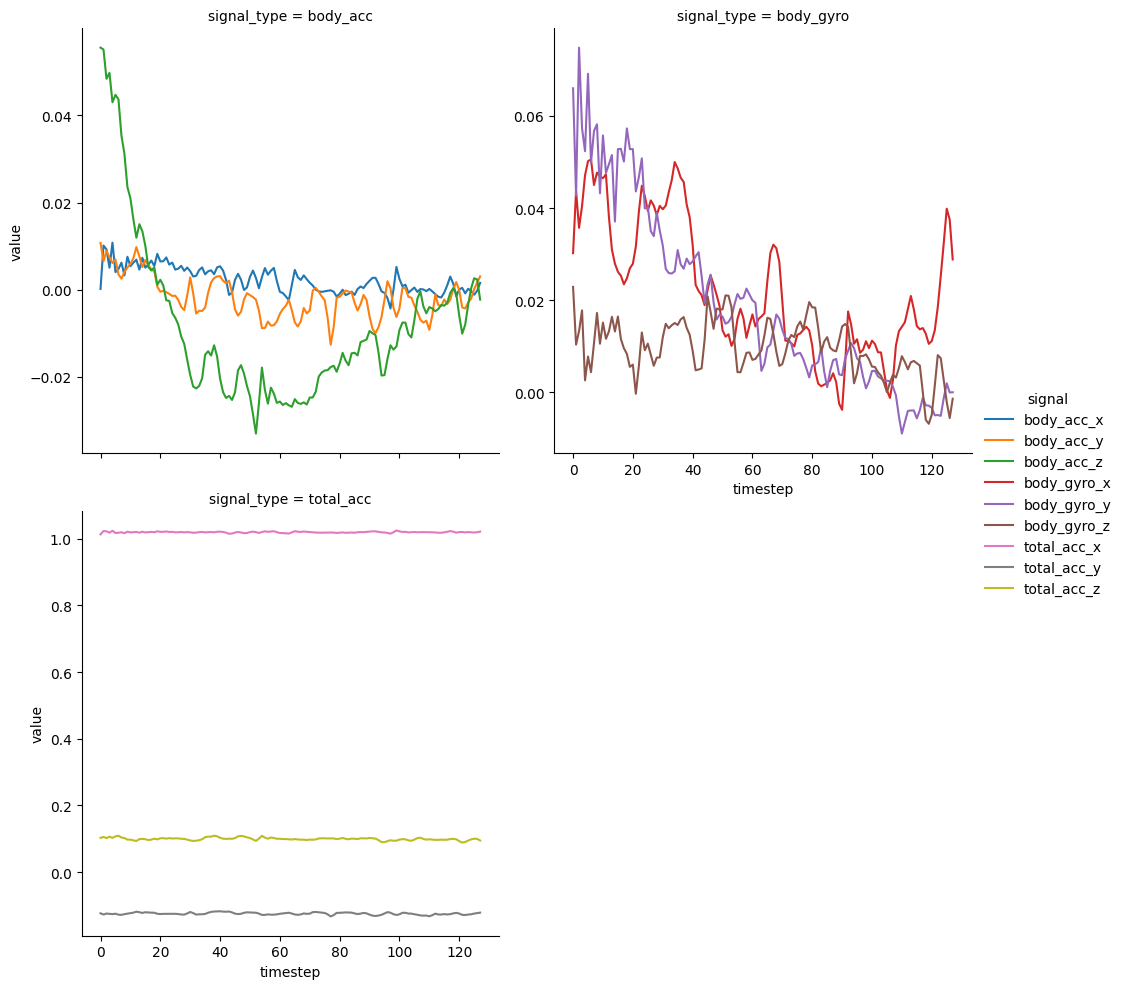

In [10]:
df_plot = dc.df_train_x.loc[0].copy()

df_plot = df_plot.reset_index().melt(
    id_vars=["timestep"],
    value_vars=df_plot.columns.tolist()
)

df_plot["signal_type"] = df_plot["signal"].str.replace("_([xyz])", "", regex=True)

sns.relplot(
    df_plot,
    kind="line",
    x="timestep",
    y="value",
    hue="signal",
    col="signal_type",
    col_wrap=2,
    facet_kws={"sharey": False}
)

There are 6 activities in total:

In [11]:
dc.df_train_y["name"].value_counts()

name
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

## Baseline Models: XGBoost

HAR comes with a set of features created from sensor data time series:

In [12]:
dc.df_train_x_tr.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
sample,,,,,,,,,,,,,,,,,,,,,
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


Although raw features provide a good amount of data separation for most activities, we are going to have issues with SITTING and STANDING being very similar:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: >

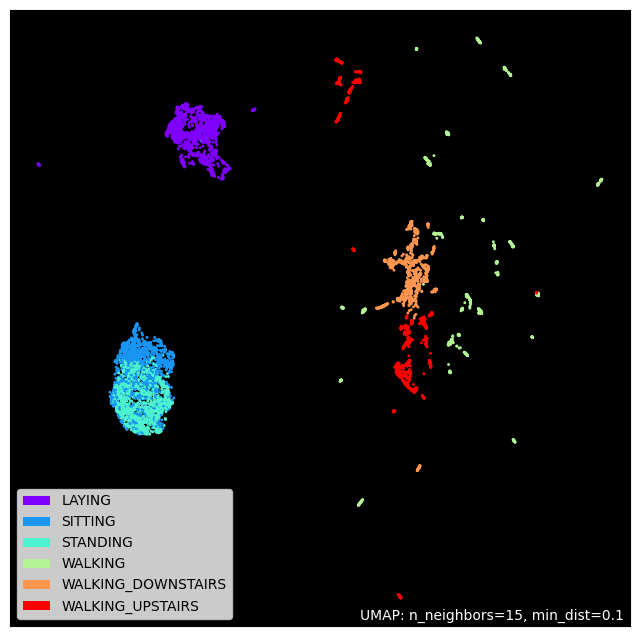

In [13]:
mapper = UMAP().fit(
    dc.df_train_x_tr.values
)

umap.plot.points(
    mapper, 
    labels=dc.df_train_y["name"],
    theme='fire'
)

### Fitting

Baseline classification results using ordinary XGBoost classifier with minimal tuning:

In [14]:
# Data preparation
x_train = dc.df_train_x_tr.values
y_train = dc.df_train_y["label"].values
x_test = dc.df_test_x_tr.values
y_test = dc.df_test_y["label"].values

eval_set = [(x_train, y_train), (x_test, y_test)]

sample_weight = compute_sample_weight(
    class_weight="balanced",
    y=y_train
)

In [15]:
params_xgb = {
    "n_estimators": 1000,
    "num_class": dc.df_train_y["label"].nunique(),
    "gamma": 0.1,
    "max_depth": 16,
    "subsample": 0.6,
    "colsample_bytree": 6/16,
    "colsample_bylevel": 6/16,
    "colsample_bynode": 6/16,
    "reg_alpha": 0.8,
    "reg_lambda": 0.8,
    "learning_rate": 0.01,
    "eval_metric": "merror",
    "early_stopping_rounds": 100,
    "seed": 42
}

In [16]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    **params_xgb
)

In [17]:
_ = xgb_model.fit(
    x_train,
    y_train,
    sample_weight=sample_weight,
    eval_set=eval_set,
    verbose=100
)

[0]	validation_0-merror:0.04693	validation_1-merror:0.16899
[100]	validation_0-merror:0.00585	validation_1-merror:0.07431
[200]	validation_0-merror:0.00258	validation_1-merror:0.07058
[300]	validation_0-merror:0.00136	validation_1-merror:0.06753
[400]	validation_0-merror:0.00027	validation_1-merror:0.06481
[500]	validation_0-merror:0.00014	validation_1-merror:0.06278
[600]	validation_0-merror:0.00000	validation_1-merror:0.06074
[700]	validation_0-merror:0.00000	validation_1-merror:0.05870
[800]	validation_0-merror:0.00000	validation_1-merror:0.05701
[900]	validation_0-merror:0.00000	validation_1-merror:0.05667
[917]	validation_0-merror:0.00000	validation_1-merror:0.05667


In [18]:
xgb_model.best_score, xgb_model.best_iteration

(0.05632846963013234, 817)

### Validation and Diagnostics

In [19]:
df_pred = dc.df_test_y.copy()
df_pred["y_pred"] = xgb_model.predict(x_test)
df_pred["y_pred_prob"] = np.max(xgb_model.predict_proba(x_test), axis=1)
df_pred["subject_id"] = dc.df_test_x.reset_index('timestep').index.unique().to_frame(index=False)["subject_id"]
df_pred["match"] = (df_pred["label"] == df_pred["y_pred"])
df_pred["no_match"] = (df_pred["label"] != df_pred["y_pred"])

Each individual in the train set repeated the same activity at least 36 times, and at least 38 times in the test set.

In [20]:
df_train_y = dc.df_train_y.copy()
df_train_y['subject_id'] = dc.df_train_x.groupby(
    ['sample', 'subject_id']
).size().reset_index(level='subject_id')['subject_id']

df_train_y.groupby(['subject_id', 'name']).size().groupby('name').min()

name
LAYING                50
SITTING               44
STANDING              47
WALKING               46
WALKING_DOWNSTAIRS    36
WALKING_UPSTAIRS      40
dtype: int64

In [21]:
df_pred.groupby(['subject_id', 'name']).size().groupby('name').min()

name
LAYING                48
SITTING               46
STANDING              44
WALKING               50
WALKING_DOWNSTAIRS    38
WALKING_UPSTAIRS      47
dtype: int64

- The model produces repeated misclassifications of the same activities by the same invididual: errors are not random

In [22]:
df_match_pct = df_pred.groupby(
    ["subject_id", "name"]
)["no_match"].agg(["mean", "sum"])

In [23]:
df_match_pct[df_match_pct["mean"] > 0]

mean  sum
subject_id name                             
2          SITTING             0.304348   14
4          SITTING             0.080000    4
           STANDING            0.089286    5
           WALKING_DOWNSTAIRS  0.022222    1
           WALKING_UPSTAIRS    0.019231    1
9          SITTING             0.180000    9
           STANDING            0.177778    8
           WALKING_UPSTAIRS    0.183673    9
10         SITTING             0.185185   10
           STANDING            0.409091   18
           WALKING             0.056604    3
           WALKING_UPSTAIRS    0.382979   18
12         SITTING             0.058824    3
           WALKING             0.020000    1
           WALKING_UPSTAIRS    0.057692    3
13         SITTING             0.020408    1
           WALKING_DOWNSTAIRS  0.148936    7
18         SITTING             0.035088    2
           WALKING_DOWNSTAIRS  0.581818   32
20         SITTING             0.015152    1
           WALKING             0.215686   11
           WALKING_DOWNSTAIRS  0.111111    5

In [24]:
print(classification_report(
    y_true=df_pred["label"],
    y_pred=df_pred["y_pred"],
    target_names=df_pred.groupby('label')['name'].value_counts().reset_index()['name'].values.tolist(),
))

                    precision    recall  f1-score   support

           WALKING       0.93      0.97      0.95       496
  WALKING_UPSTAIRS       0.91      0.93      0.92       471
WALKING_DOWNSTAIRS       0.97      0.89      0.93       420
           SITTING       0.94      0.91      0.92       491
          STANDING       0.92      0.94      0.93       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



- There's hardly any confusion between "idle" (sitting, standing, laying) and "non-idle" activities
- The mistakes arise when it comes to separating some activities within the two groups

Text(0.5, 0.98, 'Confusion Matrix: XGBoost')

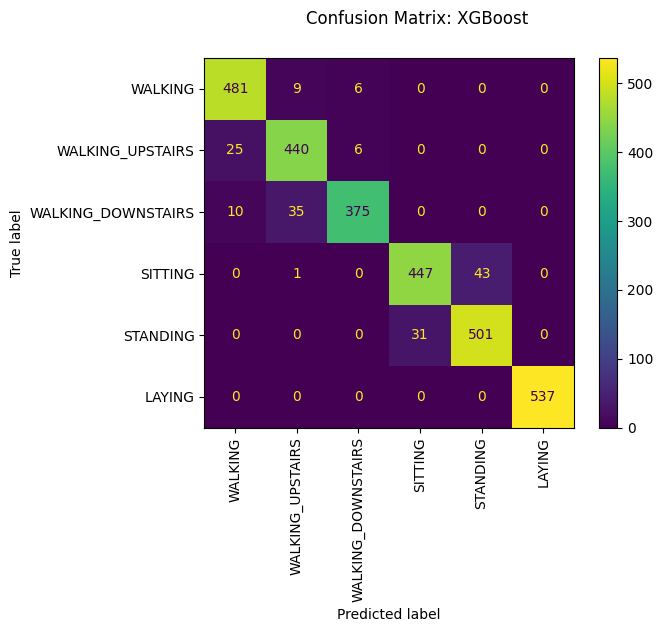

In [25]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=df_pred["label"],
        y_pred=df_pred["y_pred"],
    ),
    display_labels=list(label_to_name_map.values())
)

disp.plot(
    xticks_rotation=90
)

plt.suptitle("Confusion Matrix: XGBoost")

Here is the model classified WALKING_DOWNSTAIRS activities of one individual:

In [26]:
label_idx = df_pred.loc[
    (df_pred["subject_id"]==18)
    &(df_pred["label"]==2)
].index

df_pred.loc[label_idx]

,label,name,y_pred,y_pred_prob,subject_id,match,no_match
sample,,,,,,,
1979,2,WALKING_DOWNSTAIRS,1,0.966324,18,False,True
1980,2,WALKING_DOWNSTAIRS,1,0.655236,18,False,True
1981,2,WALKING_DOWNSTAIRS,2,0.391857,18,True,False
1982,2,WALKING_DOWNSTAIRS,2,0.449228,18,True,False
1983,2,WALKING_DOWNSTAIRS,2,0.580228,18,True,False
1984,2,WALKING_DOWNSTAIRS,2,0.911037,18,True,False
1985,2,WALKING_DOWNSTAIRS,2,0.584944,18,True,False
1986,2,WALKING_DOWNSTAIRS,2,0.538991,18,True,False
1987,2,WALKING_DOWNSTAIRS,2,0.502856,18,True,False


In [27]:
mapper = UMAP().fit(
    x_test
)

<Axes: >

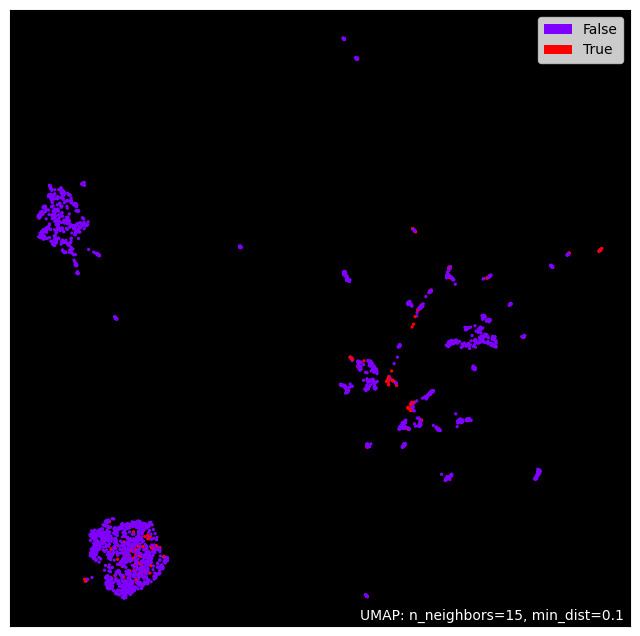

In [28]:
# TODO
umap.plot.points(
    mapper,
    labels=(df_pred["label"] != df_pred["y_pred"]),
    theme='fire'
)

<Axes: >

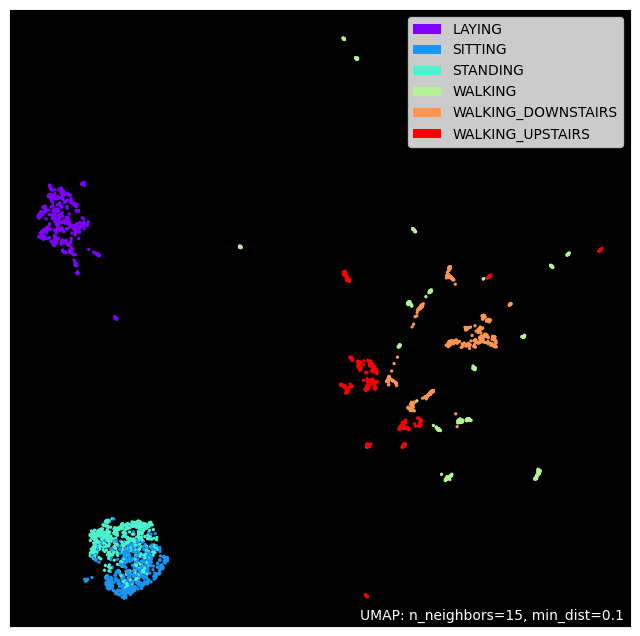

In [29]:
umap.plot.points(
    mapper,
    labels=df_pred["name"],
    theme='fire',
)

## Alternative Model: Using Time-Series Directly

From https://github.com/emadeldeen24/CA-TCC + http://arxiv.org/abs/2208.06616

Instead of training our model on labelled data straight away, we first train it to learn similarities between different representations of the same activities. Just like in the CA-TCC paper, we will be using modified versions of the data. Additionally, swapping the current measurement with that of the same activity from the same individual will also be used.

In [10]:
model_save_root_dir = "saved_models"
os.makedirs(model_save_root_dir, exist_ok=True)

cur_timestamp = datetime.now().strftime('%d_%m_%Y_%H_%M_%S')

cur_experiment_dir = os.path.join(model_save_root_dir, cur_timestamp)
cur_model_data_dir = os.path.join(cur_experiment_dir, "data")

for cur_dir in [cur_experiment_dir, cur_model_data_dir]:
    os.makedirs(cur_dir, exist_ok=True)

log_file_name = os.path.join(cur_experiment_dir, f"logs_{cur_timestamp}.log")

In [11]:
logger = _logger(log_file_name)
config = Config()

batch_size = config.batch_size
device = torch.device("cpu")

### Data Prep

In [12]:
dc.write_torch_datasets(cur_model_data_dir)

### Step 1: Self-Supervised Pre-Training

We start by training the model to create similar "internal" (latent) representations of similar readings. In the orignal paper, this was done by creating two augmented views of each reading $x$: 
- Weakly augmented view $x^w$ - there isn't too much difference between it and the original data
- Strongly augmented view $x^s$ - a bit more different:

The original paper did not use positional encoding in its Transformer layers - I have introduced that.

In [13]:
training_mode = "self_supervised"
use_subject_strong_aug = True

In [14]:
# Model objects
model = BaseModel(config).to(device)
temporal_contr_model = TC(config, device).to(device)

# Saving untrained models for visualisation later
cur_name = "untrained"
cur_save_dir = os.path.join(cur_experiment_dir, cur_name, "saved_models")
os.makedirs(cur_save_dir, exist_ok=True)

chkpoint = {'model_state_dict': model.state_dict(),
            'temporal_contr_model_state_dict': temporal_contr_model.state_dict()}

torch.save(chkpoint, os.path.join(cur_save_dir, f'ckp_last.pt'))

In [15]:
# Fetching data for model training
train_dl, valid_dl = dc.get_torch_datasets(
    output_dir=cur_model_data_dir,
    config=config,
    training_mode=training_mode,
    use_subject_strong_aug=use_subject_strong_aug
)

In [16]:
# Plotting projection head embeddings of untrained model
cur_projection_head_list = []
cur_labels = []

for data, labels, aug1, aug2 in valid_dl:
    data = data.float().to(device)
    _, features = model(data)
    z = features.transpose(1, 2)
    c_t = temporal_contr_model.seq_transformer(z)
    cur_out = temporal_contr_model.projection_head(c_t)
    
    cur_projection_head_list.append(cur_out.detach().numpy())
    cur_labels.append(labels.numpy())

Freshly initialised (untrained) model produces data representations which are hard to break into distinct groups - you just have a "blob" on UMAP plot. With that said, even without training we can see that there is a clear separation between activities which involve movement and those which do not:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


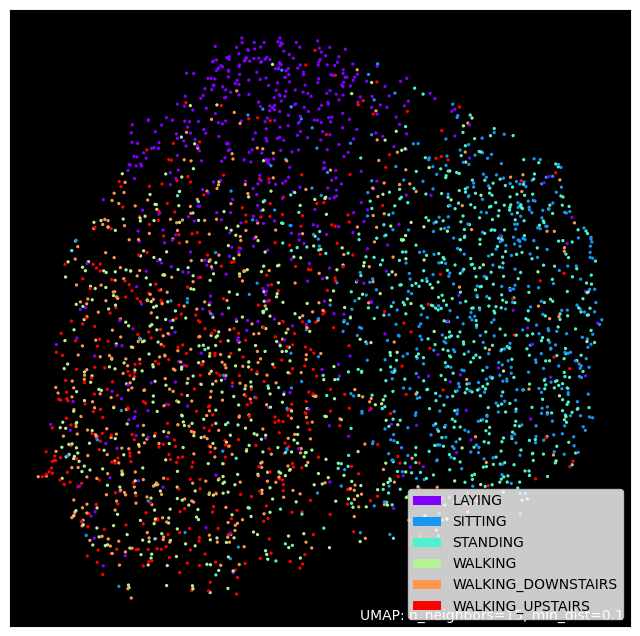

In [17]:
mapper = UMAP().fit(
    np.concatenate(cur_projection_head_list)
)

ax = umap.plot.points(
    mapper, 
    labels=np.array([label_to_name_map[x] for x in np.concatenate(cur_labels)]),
    theme='fire'
)

In [18]:
model_optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=config.lr, 
    betas=(config.beta1, config.beta2),
    weight_decay=3e-4
)

temporal_contr_optimizer = torch.optim.Adam(
    temporal_contr_model.parameters(), 
    lr=config.lr,
    betas=(config.beta1, config.beta2), 
    weight_decay=3e-4
)

In [19]:
cur_save_dir = os.path.join(cur_experiment_dir, training_mode)

In [20]:
config.num_epoch = 30

In [21]:
run_model_training(
    model=model,
    temporal_contr_model=temporal_contr_model,
    model_optimizer=model_optimizer,
    temp_cont_optimizer=temporal_contr_optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    test_dl=None,
    device=device,
    logger=logger,
    config=config,
    experiment_log_dir=cur_save_dir,
    training_mode=training_mode,
    checkpoint_metric="train_loss",
    checkpoint_mode="min"
)

Training started ....


/Users/gleb/Library/Caches/pypoetry/virtualenvs/har-examples-y11QDWQd-py3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)



Epoch : 1
Train Loss     : 13.8450	 | 	Train Accuracy     : 0.0000
Valid Loss     : 0.0000	 | 	Valid Accuracy     : 0.0000
Checkpoint saved at epoch 1 with train_loss = 13.845006942749023

Epoch : 2
Train Loss     : 13.1509	 | 	Train Accuracy     : 0.0000
Valid Loss     : 0.0000	 | 	Valid Accuracy     : 0.0000
Checkpoint saved at epoch 2 with train_loss = 13.150908470153809

Epoch : 3
Train Loss     : 12.7092	 | 	Train Accuracy     : 0.0000
Valid Loss     : 0.0000	 | 	Valid Accuracy     : 0.0000
Checkpoint saved at epoch 3 with train_loss = 12.709227561950684

Epoch : 4
Train Loss     : 12.2132	 | 	Train Accuracy     : 0.0000
Valid Loss     : 0.0000	 | 	Valid Accuracy     : 0.0000
Checkpoint saved at epoch 4 with train_loss = 12.213204383850098

Epoch : 5
Train Loss     : 11.8004	 | 	Train Accuracy     : 0.0000
Valid Loss     : 0.0000	 | 	Valid Accuracy     : 0.0000
Checkpoint saved at epoch 5 with train_loss = 11.80038070678711

Epoch : 6
Train Loss     : 11.7315	 | 	Train Accuracy  

In [22]:
chkpoint = torch.load(
    os.path.join(cur_experiment_dir, "self_supervised", "saved_models", "ckp_best.pt"), 
    map_location=device,
    weights_only=False
)

model.load_state_dict(chkpoint["model_state_dict"])
temporal_contr_model.load_state_dict(chkpoint["temporal_contr_model_state_dict"])

<All keys matched successfully>

In [23]:
# Plotting projection head embeddings after self-supervised training
cur_projection_head_list = []
cur_labels = []

for data, labels, aug1, aug2 in valid_dl:
    data = data.float().to(device)
    _, features = model(data)
    z = features.transpose(1, 2)
    c_t = temporal_contr_model.seq_transformer(z)
    cur_out = temporal_contr_model.projection_head(c_t)
    # cur_out = c_t
    
    cur_projection_head_list.append(cur_out.detach().numpy())
    cur_labels.append(labels.numpy())

After the round of self-supervised training, we are starting to see much clearer separation into differnt classes:

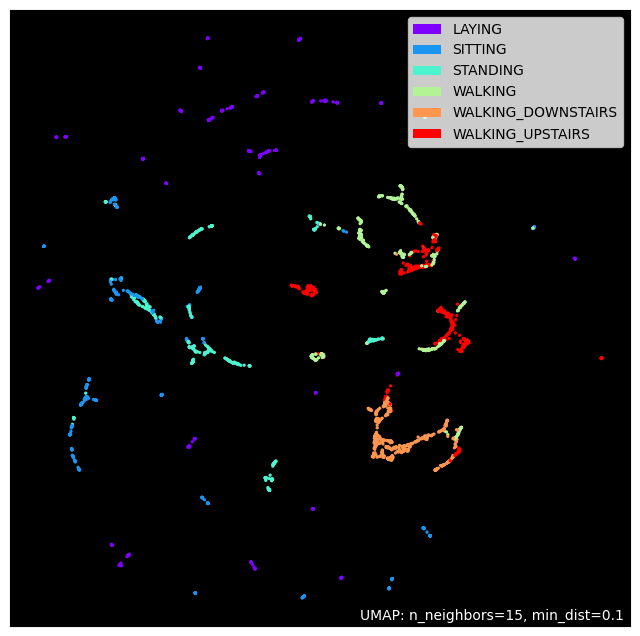

In [24]:
mapper = UMAP().fit(
    np.concatenate(cur_projection_head_list)
)

ax = umap.plot.points(
    mapper, 
    labels=np.array([label_to_name_map[x] for x in np.concatenate(cur_labels)]),
    theme='fire'
)

### Step 2: Fine-Tuning

In [25]:
training_mode = "fine_tune"

In [26]:
chkpoint = torch.load(
    os.path.join(cur_experiment_dir, "self_supervised", "saved_models", "ckp_best.pt"), 
    map_location=device,
    weights_only=False
)

In [27]:
pretrained_dict = chkpoint["model_state_dict"]
model_dict = model.state_dict()
del_list = ['logits']
pretrained_dict_copy = pretrained_dict.copy()
for i in pretrained_dict_copy.keys():
    for j in del_list:
        if j in i:
            del pretrained_dict[i]
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

temporal_contr_model.load_state_dict(chkpoint["temporal_contr_model_state_dict"])

<All keys matched successfully>

In [28]:
model_optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=config.lr, 
    betas=(config.beta1, config.beta2),
    weight_decay=3e-4
)

temporal_contr_optimizer = torch.optim.Adam(
    temporal_contr_model.parameters(), 
    lr=config.lr,
    betas=(config.beta1, config.beta2), 
    weight_decay=3e-4
)

In [29]:
# Fetching data for model training
train_dl, valid_dl = dc.get_torch_datasets(
    output_dir=cur_model_data_dir,
    config=config,
    training_mode=training_mode,
    use_subject_strong_aug=use_subject_strong_aug
)

In [30]:
cur_save_dir = os.path.join(cur_experiment_dir, training_mode)

In [31]:
config.num_epoch = 40

In [32]:
run_model_training(
    model=model,
    temporal_contr_model=temporal_contr_model,
    model_optimizer=model_optimizer,
    temp_cont_optimizer=temporal_contr_optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    test_dl=None,
    device=device,
    logger=logger,
    config=config,
    experiment_log_dir=cur_save_dir,
    training_mode=training_mode,
    checkpoint_metric="valid_acc",
    checkpoint_mode="max"
)

Training started ....

Epoch : 1
Train Loss     : 0.5471	 | 	Train Accuracy     : 0.8407
Valid Loss     : 0.3237	 | 	Valid Accuracy     : 0.9076
Checkpoint saved at epoch 1 with valid_acc = 0.907608687877655

Epoch : 2
Train Loss     : 0.1793	 | 	Train Accuracy     : 0.9379
Valid Loss     : 0.2494	 | 	Valid Accuracy     : 0.9096
Checkpoint saved at epoch 2 with valid_acc = 0.90964674949646

Epoch : 3
Train Loss     : 0.1393	 | 	Train Accuracy     : 0.9492
Valid Loss     : 0.2146	 | 	Valid Accuracy     : 0.9127
Checkpoint saved at epoch 3 with valid_acc = 0.912703812122345

Epoch : 4
Train Loss     : 0.1248	 | 	Train Accuracy     : 0.9494
Valid Loss     : 0.2061	 | 	Valid Accuracy     : 0.9260
Checkpoint saved at epoch 4 with valid_acc = 0.9259510636329651

Epoch : 5
Train Loss     : 0.1153	 | 	Train Accuracy     : 0.9522
Valid Loss     : 0.1954	 | 	Valid Accuracy     : 0.9253

Epoch : 6
Train Loss     : 0.1119	 | 	Train Accuracy     : 0.9522
Valid Loss     : 0.2046	 | 	Valid Accuracy  

In [33]:
chkpoint = torch.load(
    os.path.join(cur_experiment_dir, "fine_tune", "saved_models", "ckp_best.pt"), 
    map_location=device,
    weights_only=False
)

model.load_state_dict(chkpoint["model_state_dict"])
temporal_contr_model.load_state_dict(chkpoint["temporal_contr_model_state_dict"])

<All keys matched successfully>

In [34]:
# Plotting projection head embeddings after self-supervised training
cur_projection_head_list = []
cur_labels = []

for data, labels, aug1, aug2 in valid_dl:
    data = data.float().to(device)
    _, features = model(data)
    z = features.transpose(1, 2)
    c_t = temporal_contr_model.seq_transformer(z)
    cur_out = temporal_contr_model.projection_head(c_t)
    
    cur_projection_head_list.append(cur_out.detach().numpy())
    cur_labels.append(labels.numpy())

After supervised fine-tuning on all labelled data, we have a very clear separation between 4 activities. Overlap between Sitting and Standing suggets we've been dropping performance there though:

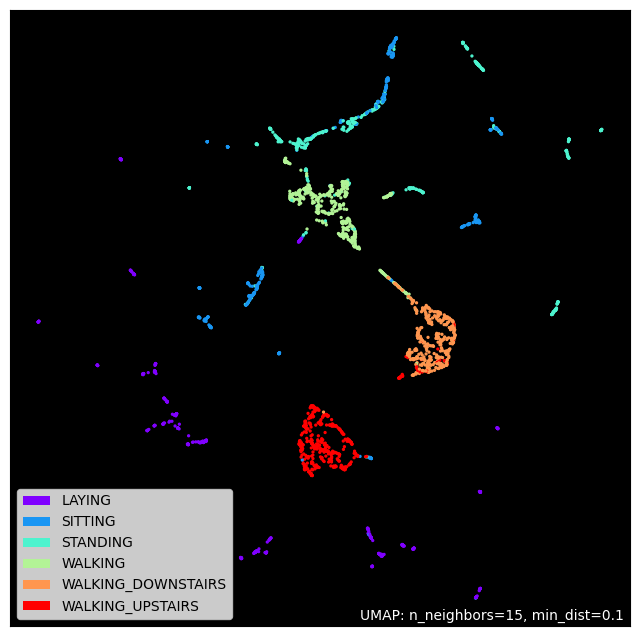

In [35]:
mapper = UMAP().fit(
    np.concatenate(cur_projection_head_list)
)

ax = umap.plot.points(
    mapper, 
    labels=np.array([label_to_name_map[x] for x in np.concatenate(cur_labels)]),
    theme='fire'
)

### Validation and Diagnostics

In [36]:
config.drop_last = False

In [37]:
_, valid_dl = dc.get_torch_datasets(
    output_dir=cur_model_data_dir,
    config=config,
    training_mode=training_mode,
    use_subject_strong_aug=use_subject_strong_aug
)

In [38]:
# Plotting projection head embeddings after self-supervised training
projection_head_list = []
pred_list = []
labels_list = []

for data, labels, aug1, aug2 in valid_dl:
    data = data.float().to(device)
    logits, features = model(data)
    z = features.transpose(1, 2)
    c_t = temporal_contr_model.seq_transformer(z)
    cur_out = temporal_contr_model.projection_head(c_t)
    
    projection_head_list.append(cur_out.detach().numpy())
    pred_list.append(torch.argmax(logits, dim=1).detach().numpy())
    labels_list.append(labels.detach().numpy())

In [39]:
projection_head_arrays = np.concatenate(projection_head_list)
labels = np.concatenate(labels_list)
pred = np.concatenate(pred_list)

In [40]:
df_pred = dc.df_test_y.copy()
df_pred["y_pred"] = pred
df_pred["subject_id"] = dc.df_test_x.reset_index('timestep').index.unique().to_frame(index=False)["subject_id"]
df_pred["match"] = (df_pred["label"] == df_pred["y_pred"])
df_pred["no_match"] = (df_pred["label"] != df_pred["y_pred"])

In [41]:
df_match_pct = df_pred.groupby(
    ["subject_id", "name"]
)["no_match"].agg(["mean", "sum"])

Added data augmentation way made an impact: we have reduced the number of individuals whose activities were misclassified (from 8 to 6):

In [42]:
df_match_pct[df_match_pct["mean"] > 0]

mean  sum
subject_id name                             
2          SITTING             0.630435   29
4          SITTING             0.120000    6
           STANDING            0.250000   14
9          SITTING             0.280000   14
           STANDING            0.444444   20
           WALKING             0.019231    1
10         SITTING             0.537037   29
           STANDING            0.477273   21
           WALKING             0.018868    1
           WALKING_UPSTAIRS    0.510638   24
12         SITTING             0.137255    7
13         WALKING_DOWNSTAIRS  0.063830    3
18         WALKING_DOWNSTAIRS  0.018182    1
20         SITTING             0.015152    1
           WALKING_UPSTAIRS    0.019608    1

- There's hardly any confusion between "idle" (sitting, standing, laying) and "non-idle" activities
- The mistakes arise when it comes to separating some activities within the two groups
- Sitting and Standing is where we are having issues at the moment, but the overall accuracy is still higher than that of vanilla classifier
- We see less overfitting

In [43]:
print(classification_report(
    y_true=df_pred["label"],
    y_pred=df_pred["y_pred"],
    target_names=df_pred.groupby('label')['name'].value_counts().reset_index()['name'].values.tolist(),
))

                    precision    recall  f1-score   support

           WALKING       0.99      1.00      0.99       496
  WALKING_UPSTAIRS       0.98      0.95      0.96       471
WALKING_DOWNSTAIRS       0.94      0.99      0.97       420
           SITTING       0.88      0.82      0.85       491
          STANDING       0.86      0.90      0.88       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



Text(0.5, 0.98, 'Confusion Matrix: CA-TCC')

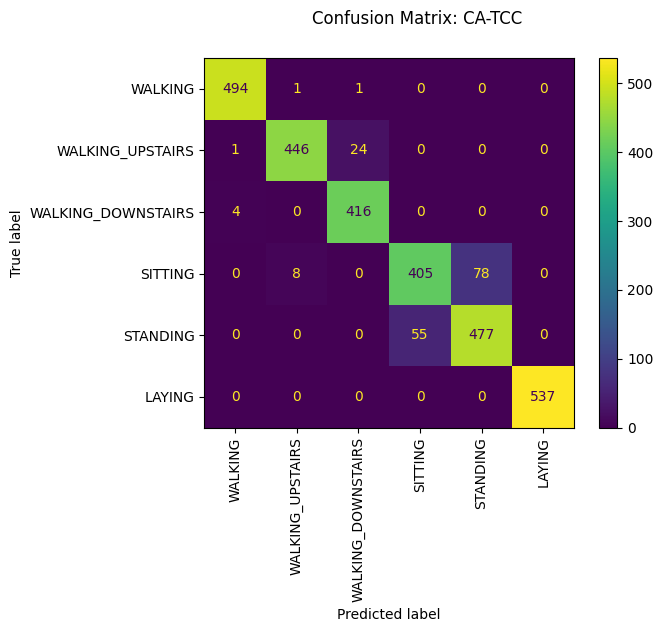

In [44]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=df_pred["label"],
        y_pred=df_pred["y_pred"],
    ),
    display_labels=list(label_to_name_map.values())
)

disp.plot(
    xticks_rotation=90
)

plt.suptitle("Confusion Matrix: CA-TCC")